In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Markov:
    def __init__(self,bCPP=True):
        self.bCPP = bCPP
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
        self.iNrTimesPerPeriod = 1.
        self.bRecalculateTime = False
        self.psymM = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        #print("..",self.iNrStates,self.iMaxTime)
        try:
            import omarkov as mlv
            if self.bCPP:
                self.psymM = mlv.MARKOVLV(self.iMaxTime,self.iMaxTime,1)
                self.psymM.vSetNrStates(iNrStates)
                return()
        except:
            print("Falling Back")
        for i in range(iMaxTime):
                tempPij = np.zeros([iNrStates,iNrStates])
                tempPost = np.zeros([iNrStates,iNrStates])
                tempPre = np.zeros([iNrStates])
                tempDK = np.zeros([iNrStates])
                tempCF = np.zeros([iNrStates])
                self.dPij.append(tempPij)
                self.dPost.append(tempPost)
                self.dPre.append(tempPre)
                self.dDK.append(tempDK)
                self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    
    def vSetDiscount(self,fIRate):
        self.dITech=fIRate
        vTemp = 1./(1.+fIRate)
        #print("Discount %.4f"%(vTemp))
        #print (self.iMaxTime, len(self.dv))
        for i in range(self.iMaxTime):
            if self.psymM:
                for j in range(self.iNrStates):
                    self.psymM.dSetDisc(i, j, j, vTemp)
            else:
                self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPij(t,i,j,fValue)
        else:
            self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPre(t,i,j,fValue)
        else:
            self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        if self.bRecalculateTime: 
            t *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.dSetPost(t,i,j,fValue)
        else:
            self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def pymBlowMeUp(self,iNrTimesPerPeriod,DefaultStateMapper = dict()):
        psymM = Markov()
        psymM.vDefineModel(self.iNrStates,iMaxTime=self.iMaxTime*iNrTimesPerPeriod)
        psymM.iNrTimesPerPeriod = iNrTimesPerPeriod
        psymM.bRecalculateTime = False
        self.vDoBlowUpStates(psymM,DefaultStateMapper) #To be done ie adjustment of v, P_ij, Pre and Post
        return(psym)
    
    def vDoBlowUpStates(self,psymM,DefaultStateMapper):
        for i in range(self.iNrStates):
            if i not in DefaultStateMapper.keys():
                print("Use %d to itself as default mapper"%(i))
                DefaultStateMapper[i] = i
        fIRate = 1./self.dv[0] - 1.
        psymM.vSetDiscount(fIRate)
        for t in range(self.iMaxTime):
            t0 = self.iMaxTime *self.iNrTimesPerPeriod
            t1 = t0 + self.iNrTimesPerPeriod
            for i in range(self.iNrStates):
                x=[t0*1,t1*1]
                y=[self.dPre[t][i],self.dPost[t][i,i]]
                newval = np.interp(list(range(t0,t1+1))*1., x, y)
                dPDefault  = 1.
                PTemp = np.zeros(self.iNrStates)
                for l in range(self.iNrStates):
                    if l == DefaultStateMapper[i]: continue
                    dTemp = self.dPij[t][i,l] / self.iNrTimesPerPeriod
                    dPDefault  -= dTemp
                    PTemp[l] = dTemp
                PTemp[DefaultStateMapper[i]] = PTemp[l]  
                for k in range(t1-t0):
                    psymM.vSetPre(t0+k,i,i,newval[k])
                    psymM.vSetPij(t0+k,i,l,PTemp[l])
                    for l in range(self.iNrStates):
                        if i == l: continue
                        psymM.vSetPost(t0+k,i,l,self.dPost[t][i,l])
                psymM.vSetPost(t1-1,i,i,newval[-1])
                    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    def dGetDK(self,iStart,iStop,iAge,iState):       
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetStartTime(iStart)
            self.psymM.vSetStopTime(iStop)
            return(self.psymM.dGetDK(iAge, iState,1))
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        if self.psymM:
            self.psymM.vSetStartTime(iStart)
            self.psymM.vSetStopTime(iStop)
            dT = 0
            for j in range(self.iNrStates):
                dT+=self.psymM.dGetCF(iAge, iState, j)
            return(dT)
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def PrintDKs(self,iStart,iStop):
        if self.bRecalculateTime: 
            iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            if self.bRecalculateTime: 
                strTemp += " %6.3f :"%(i*1./self.iNrTimesPerPeriod)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        if self.bRecalculateTime: 
        #    iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        x = []
        y = []
        for i in range(iStop,iStart+1):
            if self.bRecalculateTime:
                x.append(i*1./self.iNrTimesPerPeriod)
            else:
                x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2):
        if self.bRecalculateTime: 
        #    iAge *= self.iNrTimesPerPeriod
            iStart *= self.iNrTimesPerPeriod
            iStop *= self.iNrTimesPerPeriod
        import matplotlib.colors as mcolors
        A= []
        for i in mcolors.TABLEAU_COLORS.keys():
            A.append(i)
        for i in mcolors.BASE_COLORS.keys():
            A.append(i)
        
        xBar =[]
        hBar =[]
        bBar =[]
        cBar =[]
        y = []
        for i in range(iStop,iStart+1):
            for j in range(self.iNrStates):
                xBar.append(i+(0.5+j)*0.9/self.iNrStates)
                hBar.append(self.dGetCF(iStart,iStop,i,j))
                bBar.append(0)
                cBar.append(A[j])
            
        plt.figure(figNr)
        plt.bar(xBar,hBar,bottom=bBar, width = 0.9/self.iNrStates,color=cBar)
        plt.grid(True)


In [2]:
import matplotlib.pyplot as plt

def CreateValueVector(MaxEntries = 100):
    Values = []
    for i in range(MaxEntries): 
        myD = dict()
        myD['L'] = 0
        myD['B'] = 0
        myD['P'] = 0
        myD['A'] = 0
        myD['D'] = 0
        Values.append(myD)
    return(Values)

def AddValue(Values, time, dLia, dBonus, dPrem, dAsset, dDer):
    myD = dict()
    myD['L'] = dLia
    myD['B'] = dBonus
    myD['P'] = dPrem
    myD['A'] = dAsset
    myD['D'] = dDer
    Values[time] = myD

def LoadValues(Filename, MaxEntries = 100, Separator = ";", bTrace = False):
    Values = CreateValueVector(MaxEntries = MaxEntries)
    # Format time Symbol Value
    psymF = open(Filename,"r")
    allLines = psymF.read()
    psymF.close()
    Lines = allLines.split("\n")
    for i in Lines:
        iPrime = i.replace(" ","")
        Tokens=iPrime.split(Separator)
        if len(Tokens) <3: continue
        if bTrace: print(Tokens)
        j = int(Tokens[0])
        if j<0 or j>= MaxEntries: continue
        s = Tokens[1]
        value = float(Tokens[2])
        Values[j][s] = value
    return(Values)

def ColorScheme(strT):
    if strT == "L": return("green")
    if strT == "B": return("cyan")
    if strT == "P": return("orange")
    if strT == "A": return("red")
    if strT == "D": return("blue")
    if strT == "D-": return("blue")
    if strT == "DA": return("pink")
    if strT == "T+": return("red")
    if strT == "T-": return("blue")
    if strT == "T": return("gray")
    return('bisque')

def BuildBars(time, MyD_t, width = 0.4, liaoffset = 0.20, assetoffset = 0.60, fCS = ColorScheme, maxT = 50, scale=1, fWidth=0*2.5):
    x=[]
    y=[]
    b=[]
    c=[]
    w=[]    
    dNetPosition = MyD_t['L'] + MyD_t['B'] - (MyD_t['P'] + MyD_t['A'] + MyD_t['D'])
    
    if MyD_t == []: return(x,y,b,c,w)
    x.append(time+liaoffset)
    y.append(MyD_t['L']*scale)
    b.append(0)
    c.append(fCS('L'))
    w.append(width)
    x.append(time+liaoffset)
    y.append(MyD_t['B']*scale)
    b.append(MyD_t['L']*scale)
    c.append(fCS('B'))
    w.append(width)    
    x.append(time + assetoffset)
    y.append(MyD_t['P']*scale)
    b.append(0)
    c.append(fCS('P'))
    w.append(width)
    x.append(time + assetoffset)
    y.append(MyD_t['A']*scale)
    b.append(MyD_t['P']*scale)
    c.append(fCS('A'))
    w.append(width)
    totAsset = (MyD_t['P'] + MyD_t['A'])
    netPosition = (totAsset + MyD_t['D'])
    if MyD_t['D'] >= 0:
        x.append(time + assetoffset)
        y.append(MyD_t['D']*scale)
        b.append(totAsset*scale)
        c.append(fCS('D'))
        w.append(width)
        return(x,y,b,c,w)
    if netPosition >= MyD_t['P']:
        x.append(time + assetoffset)
        y.append((totAsset - netPosition)*scale)
        b.append(netPosition*scale)
        c.append(fCS('DA'))
        w.append(width)
        return(x,y,b,c,w)
    if netPosition >= 0:
        x.append(time + assetoffset)
        y.append(MyD_t['A']*scale)
        b.append(MyD_t['P']*scale)
        c.append(fCS('DA'))
        w.append(width)
        x.append(time + assetoffset)
        y.append((MyD_t['P']-netPosition)*scale)
        b.append(netPosition*scale)
        c.append(fCS('DP'))
        w.append(width)
        return(x,y,b,c,w)
    x.append(time + assetoffset)
    y.append(MyD_t['A']*scale)
    b.append(MyD_t['P']*scale)
    c.append(fCS('DA'))
    w.append(width)
    x.append(time + assetoffset)
    y.append(MyD_t['P']*scale)
    b.append(0)
    c.append(fCS('DP'))
    w.append(width)
    x.append(time + assetoffset)
    y.append(-netPosition*scale)
    b.append(netPosition*scale)
    c.append(fCS('D-'))
    w.append(width)
    return(x,y,b,c,w)

def BuildBarsNet(Values, width = 0.8, offset = 0.40, fCS = ColorScheme, maxT = 50, scale=1):
    x=[]
    y=[]
    b=[]
    c=[]
    w=[]
    
    for time in range(min(maxT,len(Values))):
        MyD_t= Values[time]
        dNetPosition = MyD_t['L'] - (MyD_t['P'] + MyD_t['A'] + MyD_t['D'])
        if dNetPosition >= 0:
            x.append(time+offset)
            y.append(dNetPosition*scale)
            b.append(0)
            c.append(fCS('T+'))
            w.append(width)
        else:
            x.append(time+offset)
            y.append(-dNetPosition*scale)
            b.append(dNetPosition*scale)
            c.append(fCS('T-'))
            w.append(width)
    return(x,y,b,c,w)
        

def CalcDuration(Values, v=0.969):
    piA = 0
    piL = 0
    piLT = 0
    dA = 0
    dL = 0
    dLT = 0
    for i in range(len(Values)):
        MyD_t = Values[i]
        if MyD_t == []: continue
        DeltaA = MyD_t['P'] + MyD_t['A'] + MyD_t['D']
        DeltaL = MyD_t['L']
        DeltaLT = MyD_t['L'] + MyD_t['B']
        piA += DeltaA * v**i
        dA += DeltaA * i * v**i
        piL += DeltaL * v**i
        dL += DeltaL * i * v**i
        piLT += DeltaLT * v**i
        dLT += DeltaLT * i * v**i
    dA /= piA
    dL /= piL
    dLT /= piLT
    
    return(piA,piL,piLT,dA, dL,dLT)
    


def doPlot(Values, FigNr =1, bDur = True, maxT=50, FigName ="test.pdf", FigName2 ="test2.pdf", scale=1):
    xT = []
    yT = []
    bT = []
    cT = []
    wT = []

    for i in range(min(maxT,len(Values))):
        x,y,b,c,w = BuildBars(i, Values[i],scale=scale)
        xT += x
        yT += y
        bT += b
        cT += c
        wT += w
             
    plt.figure(FigNr)
    plt.grid(True)
    plt.bar(xT,yT,color=cT, bottom = bT, width = wT, edgecolor='k', linewidth=0.2)
    xmin, xmax, ymin, ymax = plt.axis([None, maxT,None,None])
    piA,piL,piLT,dA, dL,dLT =  CalcDuration(Values)
    x = xmin + 0.5*(xmax - xmin)
    y = 0.8 * ymax
    plt.text(x,y,"%-2s %9.1f   d: %4.1f\n%-2s %9.1f   d: %4.1f"%("A:", piA*scale, dA,"L:", piL*scale, dL), backgroundcolor="yellow")
 
    plt.plot(dA,ymin,"ro",markersize=10,clip_on=False)
    plt.plot(dL,ymin,"go",markersize=10,clip_on=False)
    plt.plot(dLT,ymin,"o",color='cyan',markersize=10,clip_on=False)
    plt.savefig(FigName,dpi=1200)
    
    x,y,b,c,w = BuildBarsNet(Values,scale=scale,maxT = maxT)
    plt.figure(FigNr+1)
    plt.grid(True)
    plt.bar(x,y,color=c, bottom = b, width = w, edgecolor='k', linewidth=0.2)
    xmin, xmax, ymin, ymax = plt.axis([None, maxT,None,None])
    plt.savefig(FigName2,dpi=1200)

In [3]:
def Qx(gender,x,t,param =[]):
    # This is our default mortality
    if gender == 0:
        a =[2.34544649e+01,8.70547812e-02,7.50884047e-05,-1.67917935e-02]
    else:
        a =[2.66163571e+01,8.60317509e-02,2.56738012e-04,-1.91632675e-02]
    return(max(0,min(1,np.exp(a[0]+(a[1]+a[2]*x)*x+a[3]*t))))

def SxFlat(gender,x,t,param =[0.03]):
    return(param[0])

def SxNull(gender,x,t,param =[0.00]):
    return(SxFlat(gender,x,t,param =param))

def SxNorm(gender,x,t,param =[0.035]):
    return(SxFlat(gender,x,t,param =param))

def SxLow(gender,x,t,param =[0.005]):
    return(SxFlat(gender,x,t,param =param))

def SxHigh(gender,x,t,param =[0.005]):
    MyVec=[0.15,0.06,0.035]#[0.10,0.10,0.07,0.035]
    return(MyVec[min(t,len(MyVec)-1)])

class Annuity(Markov):
    def __init__(self, NrPayments = 4, bPre=True,iRate = 0.02,PaymentStart=0,PaymentEnd=120,Benefit =1):
        psymSuper = super()
        self.psymSuper = psymSuper
        psymSuper.__init__()
        if bPre:
            self.fPre = (NrPayments + 1.)/(2*NrPayments) * Benefit
        else:
            self.fPre = (NrPayments - 1.)/(2*NrPayments) * Benefit
        self.fPost = Benefit - self.fPre
        v = 1./(1.+iRate)
        self.iMaxTime=120
        psymSuper.vDefineModel(2,iMaxTime=self.iMaxTime)
        psymSuper.vSetDiscount(iRate)
        for t in range(self.iMaxTime):
            if t>= PaymentStart and t < PaymentEnd:
                psymSuper.vSetPre(t,0,0,self.fPre)
                psymSuper.vSetPost(t,0,0,self.fPost)

    def dSetQx(self,age,qx):
        self.psymSuper.vSetPij(age,0,0,1-qx)
        self.psymSuper.vSetPij(age,0,1,qx)
        
    def dGetaex(self,age):
        return(self.psymSuper.dGetDK(self.iMaxTime-1,0,age,0))
    
class Capital(Markov):
    def __init__(self, iRate = 0.02,PaymentStart=0,PaymentEnd=120, Maturity =120, BenDeath = 1, BenEndowment=1):
        psymSuper = super()
        self.psymSuper = psymSuper
        psymSuper.__init__()
        v = 1./(1.+iRate)
        self.iMaxTime=120
        PaymentEnd = min(PaymentEnd,Maturity)
        psymSuper.vDefineModel(2,iMaxTime=self.iMaxTime)
        psymSuper.vSetDiscount(iRate)
        for t in range(self.iMaxTime):
            if t>= PaymentStart and t < PaymentEnd:
                psymSuper.vSetPost(t,0,1,BenDeath)
        psymSuper.vSetPre(Maturity,0,1,BenEndowment)

    def dSetQx(self,age,qx):
        self.psymSuper.vSetPij(age,0,0,1-qx)
        self.psymSuper.vSetPij(age,0,1,qx)
        
    def dGetAx(self,age):
        return(self.psymSuper.dGetDK(self.iMaxTime-1,0,age,0))
    
class Annuity2Ord(Markov):
    def __init__(self, NrPayments = 4, bPre=True,iRate = 0.02,PaymentStart=0,PaymentEnd=120,Benefit =1):
        psymSuper = super()
        self.psymSuper = psymSuper
        psymSuper.__init__()
        if bPre:
            self.fPre = (NrPayments + 1.)/(2*NrPayments) * Benefit
        else:
            self.fPre = (NrPayments - 1.)/(2*NrPayments) * Benefit
        self.fPost = Benefit - self.fPre
        v = 1./(1.+iRate)
        self.iMaxTime=120
        psymSuper.vDefineModel(3,iMaxTime=self.iMaxTime)
        psymSuper.vSetDiscount(iRate)
        for t in range(self.iMaxTime):
            if t>= PaymentStart and t < PaymentEnd:
                psymSuper.vSetPre(t,0,0,self.fPre)
                psymSuper.vSetPost(t,0,0,self.fPost)

    def dSetQxSx(self,age,qx,sx):
        if qx+sx>=1:
            sx = 1.-qx
        self.psymSuper.vSetPij(age,0,0,1-qx-sx)
        self.psymSuper.vSetPij(age,0,1,qx)
        self.psymSuper.vSetPij(age,0,2,sx)
        
    def dSetSurrenderValue(self,age,dValue):
        self.psymSuper.vSetPost(age,0,2,dValue)
        
    def dGetaex(self,age):
        return(self.psymSuper.dGetDK(self.iMaxTime-1,0,age,0))
    
class Capital2Ord(Markov):
    def __init__(self, iRate = 0.02,PaymentStart=0,PaymentEnd=120, Maturity =120, BenDeath = 1, BenEndowment=1):
        psymSuper = super()
        self.psymSuper = psymSuper
        psymSuper.__init__()
        v = 1./(1.+iRate)
        self.iMaxTime=120
        PaymentEnd = min(PaymentEnd,Maturity)
        psymSuper.vDefineModel(3,iMaxTime=self.iMaxTime)
        psymSuper.vSetDiscount(iRate)
        for t in range(self.iMaxTime):
            if t>= PaymentStart and t < PaymentEnd:
                psymSuper.vSetPost(t,0,1,BenDeath)
        psymSuper.vSetPre(Maturity,0,1,BenEndowment)
        #print("Endonment",BenEndowment)

    def dSetQxSx(self,age,qx,sx):
        self.psymSuper.vSetPij(age,0,0,1-qx-sx)
        self.psymSuper.vSetPij(age,0,1,qx)
        self.psymSuper.vSetPij(age,0,2,sx)
        
    def dSetSurrenderValue(self,age,dValue):
        self.psymSuper.vSetPost(age,0,2,dValue)
        
    def dGetAx(self,age):
        return(self.psymSuper.dGetDK(self.iMaxTime-1,0,age,0))
        

In [4]:
def AddPolicyCapital(Policies, Age, Gender, sBenefit, sPremium, bDeath, bMaturity,Premium, iTechn, dRKW, pdRKW):
    Policies.append(["C",Age,Gender,sBenefit,sPremium,bDeath,bMaturity,Premium, iTechn, dRKW, pdRKW])

def AddPolicyAnnuity(Policies, Age, Gender, sBenefit, sPremium, bDeath, bMaturity,Premium, iTechn, dRKW, pdRKW):
    Policies.append(["A",Age,Gender,sBenefit,sPremium,bDeath,bMaturity,Premium, iTechn, dRKW, pdRKW])

    
def MapToPointers(Portfolio, Qx):
    Pointers = []
    for i in Portfolio:
        Type, Age,Gender,sBenefit,sPremium,bDeath,bMaturity,Premium, iTechn, dRKW, pdRKW = i
        if Type == "C":
            psymB = Capital(iRate = iTechn,PaymentStart=0,PaymentEnd=sBenefit-Age, Maturity =sBenefit-Age, BenDeath = bDeath, BenEndowment=bMaturity)
        else:
            psymB = Annuity(NrPayments = 4, bPre=True,iRate = iTechn,PaymentStart=sBenefit-Age,PaymentEnd=120-Age,Benefit =bDeath) 
        #print(sPremium,"PP",Premium)
        psymP = Annuity(NrPayments = 1, bPre=True,iRate = iTechn,PaymentStart=0,PaymentEnd=sPremium-Age,Benefit =-Premium)
        #print(psymP.dGetaex(0))
        for j in range(0,120-Age):
            qx =  Qx(Gender,j+Age,2020)
            psymB.dSetQx(j,qx)
            psymP.dSetQx(j,qx)
        Pointers.append([psymB,psymP])
        #psymP.PrintDKs(20,0)
    return(Pointers)

def MapToPointers2(Portfolio, Pointers, Qx, SxCap, SxAnn):
    Pointers2 = []
    for i in range(len(Portfolio)):
        Type, Age,Gender,sBenefit,sPremium,bDeath,bMaturity,Premium, iTechn, dRKW, pdRKW  = Portfolio[i]
        p = Pointers[i]
        if Type == "C":
            psymB = Capital2Ord(iRate = iTechn,PaymentStart=0,PaymentEnd=sBenefit-Age, Maturity =sBenefit-Age, BenDeath = bDeath, BenEndowment=bMaturity)
            psymSx = SxCap
            psymP = Annuity2Ord(NrPayments = 1, bPre=True,iRate = iTechn,PaymentStart=0,PaymentEnd=sPremium-Age,Benefit =-Premium)
        else:
            psymB = Annuity2Ord(NrPayments = 4, bPre=True,iRate = iTechn,PaymentStart=sBenefit-Age,PaymentEnd=120-Age,Benefit =bDeath) 
            psymSx = SxAnn
            psymP = Annuity2Ord(NrPayments = 1, bPre=True,iRate = iTechn,PaymentStart=0,PaymentEnd=sPremium-Age,Benefit =-Premium)
        #print(sPremium,"PP",Premium)
        
        #print(psymP.dGetaex(0)) 
        for j in range(0,120-Age):
            qx =  Qx(Gender,j+Age,2020)
            sx = psymSx(Gender,j+Age,j)
            #print(j,qx,sx)
            psymB.dSetQxSx(j,qx,sx)
            psymP.dSetQxSx(j,qx,sx)
            #dValue = dRKW*(p[0].dGetDK(120-Age,0,j,0)+p[1].dGetDK(120-Age,0,j,0))
            #print(j,120-Age,p[0].dGetDK(120-Age,0,j,0),p[1].dGetDK(120-Age,0,j,0))
            psymB.dSetSurrenderValue(j,dRKW*p[0].dGetDK(120-Age,0,j,0))
            psymP.dSetSurrenderValue(j,dRKW*p[1].dGetDK(120-Age,0,j,0))
        Pointers2.append([psymB,psymP])
        #psymP.PrintDKs(20,0)
    return(Pointers2)

def CalcReservesAndCashFlows(Pointers,nMaxT=50,bChatter=False):
    MRB = np.zeros(nMaxT)
    MRP = np.zeros(nMaxT)
    CFB = np.zeros(nMaxT)
    CFP = np.zeros(nMaxT)
    dDKTot =0
    iC = 0
    for p in Pointers:
        if bChatter:
            dDK =  p[0].dGetDK(nMaxT,0,0,0) +  p[1].dGetDK(nMaxT,0,0,0)
            dDKTot += dDK
            print("P %4d: MR-Policy %10.1f MR Tot %10.1f"%(iC, dDK, dDKTot))
        iC += 1 
        for i in range(nMaxT):
            MRB[i] += p[0].dGetDK(nMaxT,0,i,0)
            MRP[i] += p[1].dGetDK(nMaxT,0,i,0)
            CFB[i] += p[0].dGetCF(nMaxT,0,i,0)
            CFP[i] += p[1].dGetCF(nMaxT,0,i,0)
    return(MRB,MRP,CFB,CFP)

def PrintCalcDuration(CFB,CFP,i=0.03):
    v=1./(1.+i)
    dVal = 0
    dXVal = 0
    nMaxT = len(CFB)
    for j in range(nMaxT):
        dVal += (CFB[j]+CFP[j])* v**j
        dXVal += j *(CFB[j]+CFP[j])* v**j
    print("Duartion %6.2f"%(dXVal/dVal))

def fCalcDuration(CFB,i=0.03):
    v=1./(1.+i)
    dVal = 0
    dXVal = 0
    nMaxT = len(CFB)
    for j in range(nMaxT):
        dVal += (CFB[j])* v**j
        dXVal += j *(CFB[j])* v**j
    return(dXVal/dVal)
    
    
def PlotCF(MRB,MRP,CFB,CFP):
    plt.figure(1)
    plt.subplot(1,2,1)
    plt.plot(range(len(MRB)),MRB)
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(range(len(MRP)),MRP)
    plt.grid(True)
    plt.figure(2)
    plt.subplot(1,2,1)
    plt.bar(range(len(CFB)),CFB)
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.bar(range(len(CFP)),CFP)
    plt.grid(True)
    
def PlotCFShort(CFB,CFP, strTitle="Test", figNr=1):
    plt.figure(figNr)
    TCF = CFB+CFP
    plt.bar(range(len(TCF)),TCF)
    plt.title(strTitle)
    plt.grid(True)
    plt.savefig(strTitle+".png")

In [5]:
Portfolio = []
AddPolicyCapital(Portfolio,50,0,65,50,6000000000,300000000,0,0.02,1,None)
AddPolicyCapital(Portfolio,40,1,62,50,7500000000,300000000,6000000,0.02,1,None)
AddPolicyCapital(Portfolio,30,1,69,69,600000000,450000000,3000,0.02,1,None)
AddPolicyAnnuity(Portfolio,50,1,60,55,6000000,0,0,0.02,1,None)
AddPolicyAnnuity(Portfolio,65,1,60,55,4000000,0,0,0.02,1,None)
AddPolicyAnnuity(Portfolio,75,1,60,55,4000000,0,0,0.02,1,None)
AddPolicyAnnuity(Portfolio,85,1,60,55,40000000,0,0,0.02,1,None)

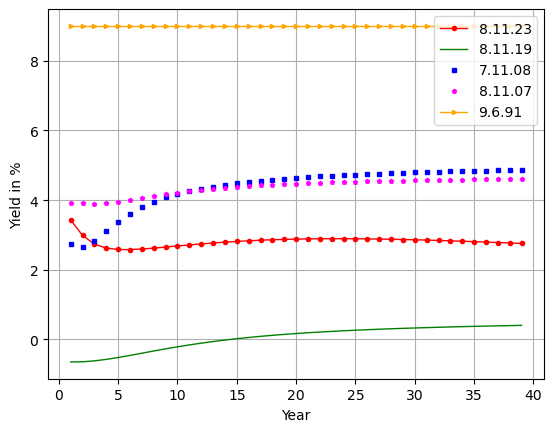

In [6]:
def iptt(t,b,tau):
    tot = b[0]
    #print(tot)
    tot += b[1] * (1 - np.exp(-t/tau[0]))/(t/tau[0])
    #print(tot)
    tot += b[2] * ((1 - np.exp(-t/tau[0]))/(t/tau[0])- np.exp(-t/tau[0]))
    #print(tot)
    tot += b[3] * ((1 - np.exp(-t/tau[1]))/(t/tau[1])- np.exp(-t/tau[1]))
    #print(tot)
    return(tot)
                   
def irate(t,k):
    if t==0: return(0)
    StrParam="""Parameter
8.11.23 1.282 2.535  2.395 4.977 0.635 14.720
8.11.19 0.655 -1.278 12.114 -14.181 2.429 2.542
7.11.08 5.104 -4.018 1.862 -7.349 0.250 1.190
8.11.07 4.758 -0.942 0.762 -2.646 0.931 2.106"""
    if k==0:
        b =[1.282, 2.535,  2.395, 4.977]
        tau = [0.635, 14.720]         
    if k==1:
        b =[0.655, -1.278, 12.114, -14.181]
        tau =[2.429, 2.542]
    if k==2:
        b =[5.104, -4.018, 1.862, -7.349] 
        tau =[0.250, 1.190]
    if k==3:
        b=[4.758, -0.942, 0.762, -2.646]
        tau=[0.931, 2.106]
    if k==4:
        b=[9.0, 0., 0., 0]
        tau=[1., 1.]
    if k==-1:
        b=[2.0, 0., 0., 0]
        tau=[1., 1.]
    return(iptt(t,b,tau)*0.01)

def dPi(AssetCF, LiaCF, Param):
    dPiL=0
    dPiA=0
    #print(dPiA)
    #print("----")
    #print(dPiL)
    iNrRate = Param[0]
    for i in range(len(AssetCF)):
        dPiA += AssetCF[i] * (1+ irate(i,iNrRate))**(-i)
    for i in range(len(LiaCF)):
        dPiL += LiaCF[i] * (1+ irate(i,iNrRate))**(-i)  
    #print(" A %10.1f L %10.1f Difference %10.1f"%(dPiA, dPiL,dPiA-dPiL))
    return(dPiA-dPiL)     

cols =['red','green','blue','magenta','orange']
legend =['8.11.23','8.11.19','7.11.08','8.11.07','9.6.91']
symb =['-o','-','s','p','->']
plt.figure(1)
for k in range(0,5):
    x=[]
    y=[]
    for i in range(1,40):
        x.append(i)
        y.append(100*irate(i,k))
    plt.plot(x,y,symb[k],color=cols[k],markersize=3,linewidth=1)
plt.grid(True)
plt.xlabel("Year")
plt.ylabel("Yield in %")
plt.legend(legend)
plt.savefig("irates.png")

In [7]:
strTitle =[]
AllCF =[]

strTitle.append("Stat No Lapses")
print(strTitle[-1])

p = MapToPointers(Portfolio, Qx)
MRB,MRP,CFB,CFP = CalcReservesAndCashFlows(p, bChatter=True)
PrintCalcDuration(CFB,CFP)
temp = dPi(CFB, -CFP, [0])
#PlotCF(MRB,MRP,CFB,CFP)
AllCF.append([CFB,CFP])

strTitle.append("FV Low Lapses")
print(strTitle[-1])
p2 = MapToPointers2(Portfolio,p, Qx, SxLow,SxNull)
MRB1,MRP1,CFB1,CFP1 = CalcReservesAndCashFlows(p2)
PrintCalcDuration(CFB1,CFP1)
temp = dPi(CFB1, -CFP1, [0])
AllCF.append([CFB1,CFP1])

strTitle.append("FV Normal Lapses")
print(strTitle[-1])
p3 = MapToPointers2(Portfolio,p, Qx, SxNorm,SxNull)
MRB2,MRP2,CFB2,CFP2 = CalcReservesAndCashFlows(p3)
PrintCalcDuration(CFB2,CFP2)
temp = dPi(CFB2, -CFP2, [0])
AllCF.append([CFB2,CFP2])

strTitle.append("FV High Lapses")
print(strTitle[-1])
p4 = MapToPointers2(Portfolio,p, Qx, SxHigh,SxNull)
MRB3,MRP3,CFB3,CFP3 = CalcReservesAndCashFlows(p4)
PrintCalcDuration(CFB3,-CFP3)
temp = dPi(CFB3, CFP3, [0])
AllCF.append([CFB3,CFP3])


Stat No Lapses
P    0: MR-Policy 611230936.0 MR Tot 611230936.0
P    1: MR-Policy 263506050.4 MR Tot 874736986.4
P    2: MR-Policy 214492702.0 MR Tot 1089229688.5
P    3: MR-Policy 102431150.7 MR Tot 1191660839.2
P    4: MR-Policy 73561987.0 MR Tot 1265222826.2
P    5: MR-Policy 50617170.4 MR Tot 1315839996.6
P    6: MR-Policy 289253885.6 MR Tot 1605093882.2
Duartion  14.50
FV Low Lapses
Duartion  13.79
FV Normal Lapses
Duartion  10.65
FV High Lapses
Duartion   9.02


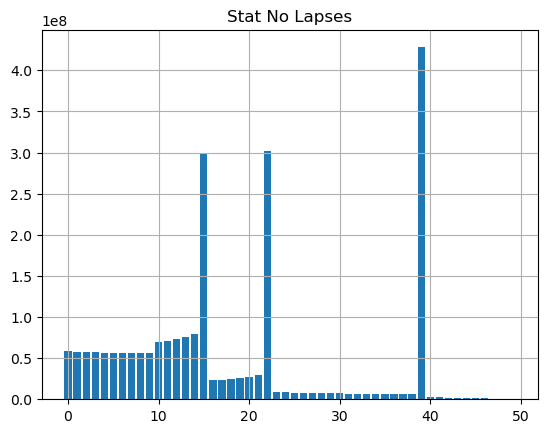

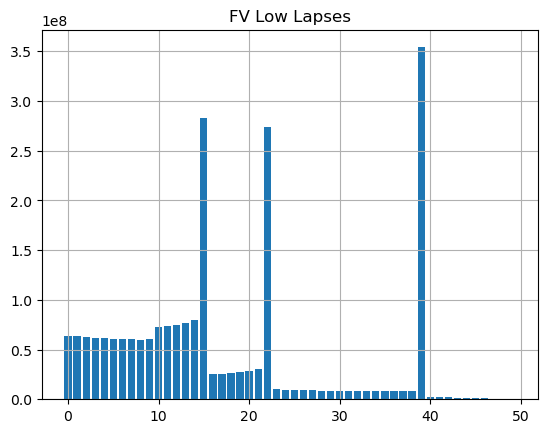

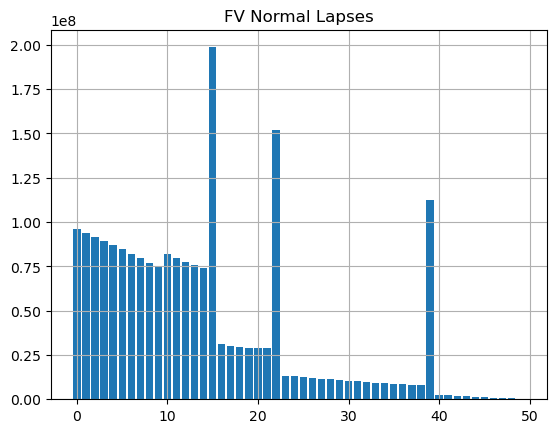

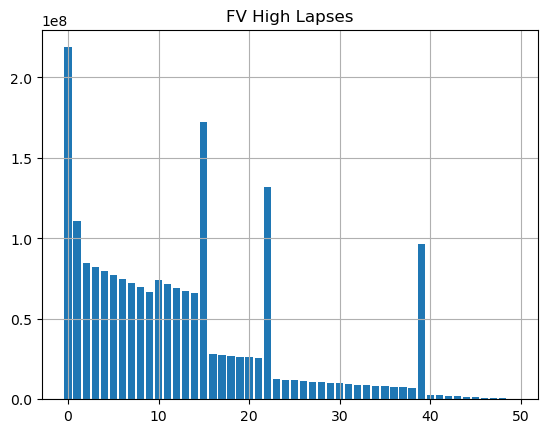

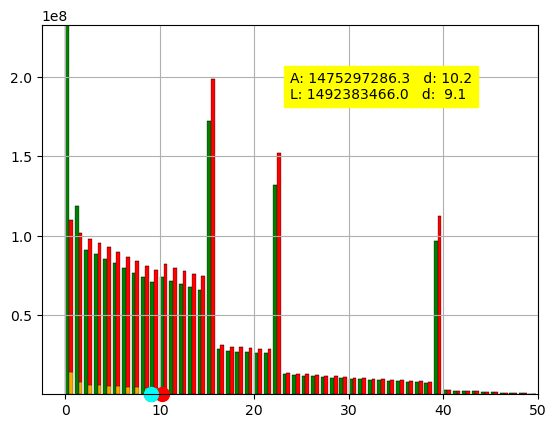

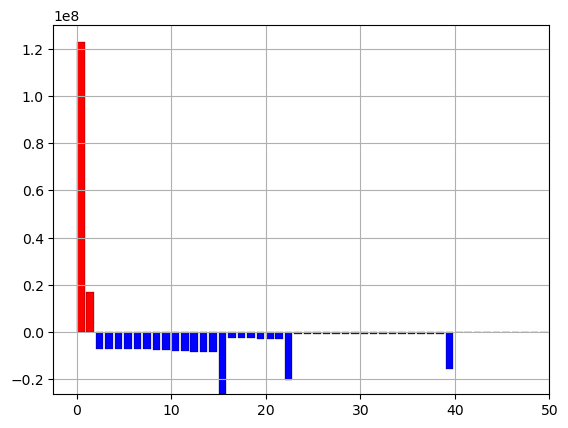

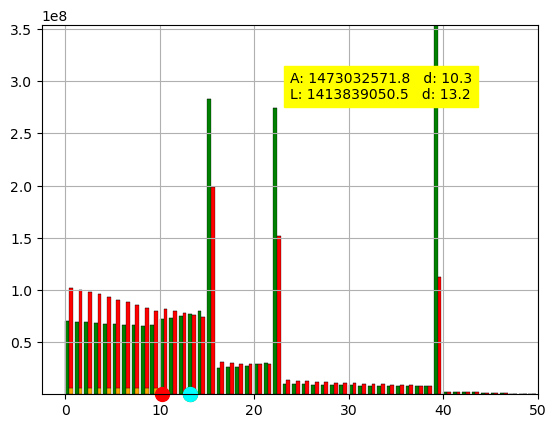

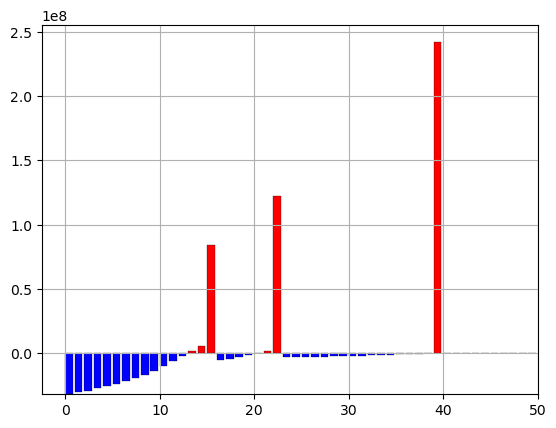

In [8]:
for i in range(len(strTitle)):
    CFBx,CFPx = AllCF[i]
    PlotCFShort(CFBx,CFPx, strTitle=strTitle[i], figNr=i)

ValuesHighLapseNoralAA = CreateValueVector(MaxEntries = 100)
ValuesLowLapseNoralAA = CreateValueVector(MaxEntries = 100)
CFA = AllCF[2] # Normal
CFB = AllCF[3] # High
CFC = AllCF[1] # Low
CFTA = CFA[0]+CFA[1]
CFTB = CFB[0]+CFB[1]
CFTC = CFC[0]+CFC[1]
for i in range(len(CFTA)):
    dLia = CFB[0][i]
    dPrem = - CFB[1][i]
    dBonus = 0
    dAsset = CFTA[i]
    dDer = 0
    #print("A",i,dLia, dBonus, dPrem, dAsset, dDer)
    AddValue(ValuesHighLapseNoralAA, i, dLia, dBonus, dPrem, dAsset, dDer)
    #print(ValuesHighLapseNoralAA[i])
    dLia = CFC[0][i]
    dPrem = - CFC[1][i]
    dBonus = 0
    dAsset = CFTA[i]
    dDer = 0
    #print("B",i,dLia, dBonus, dPrem, dAsset, dDer)
    AddValue(ValuesLowLapseNoralAA, i, dLia, dBonus, dPrem, dAsset, dDer)
    #print(ValuesLowLapseNoralAA[i])
    
#print(ValuesHighLapseNoralAA)
    
doPlot(ValuesHighLapseNoralAA, FigNr =len(strTitle), bDur = True, maxT=50, FigName ="highLapseALM.png", FigName2 ="highLapseALM2.png", scale=1)
doPlot(ValuesLowLapseNoralAA, FigNr =len(strTitle)+2, bDur = True, maxT=50, FigName ="lowLapseALM.png", FigName2 ="lowLapseALM2.png", scale=1)

**PnL Insurance Co**

1) Passive FV, MR-FV, SHE

2) Active Assets

PnL = Change in hedged Assets
    += Return in Private Assets (ie whole B/S except shares)
    += Return in equities



In [10]:
Scenarios =[]
ScenariosCapital = []
legend =['8.11.23','8.11.19','7.11.08','8.11.07','June 1991']
lapses =['normal','low','low','normal','high']
defaults = [0.0020, 0.0016, 0.0049, 0.0020, 0.0058]
equity =[0.07, 0.07, 1993./4470, 0.07, 1034.93/1107.33 ]
AssetCF =[AllCF[2],AllCF[2],AllCF[2],AllCF[2],AllCF[2],AllCF[2]]
LiaCF =[AllCF[2],AllCF[1],AllCF[1],AllCF[2],AllCF[2],AllCF[3]]

for i in range(5):
    Scenarios.append([legend[i],lapses[i],i,defaults[i],equity[i],AssetCF[i], LiaCF[i]])
    
for i in [0,1,2,4]:
    for j in [0,2,4]:
        for k in range(4):
            for l in range(5):
                strName ="%d-%d-%d-%d"%(i,j,k,l)
                ScenariosCapital.append([strName,"",l,defaults[i],equity[j],AssetCF[i], LiaCF[k]])

print("Nr Econom. Sceanrios ",len(Scenarios))            
print("Nr Capital Sceanrios ",len(ScenariosCapital))

Nr Econom. Sceanrios  5
Nr Capital Sceanrios  240


In [11]:
AssetAllocations =[]
PctPrivate = [0., 0.1, 0.2, 0.3]
PctEquity = [0., 0.1, 0.2, 0.3]
DurMismatch = [-3,-1,0,1,3]

iNr =0
for i in range(len(PctPrivate)):
    for j in range(len(PctEquity)):
        for k in range(len(DurMismatch)):
            AssetAllocations.append([iNr,PctPrivate[i],PctEquity[j],DurMismatch[k]])
            iNr+=1

print("Nr Asset Alloc. Sceanrios ",len(AssetAllocations))

Nr Asset Alloc. Sceanrios  80


In [12]:
def TransformAA(NeutralCF, dDeltaDur):
    NewAssetCF = np.zeros(len(NeutralCF))
    for i in range(len(NeutralCF)):
        NewAssetCF[max(0,min(len(NeutralCF)-1,i+dDeltaDur))] += NeutralCF[i]
    return(NewAssetCF)

import copy

def CalcPnL(EcoScen, SAA, SHE=6, MR=94, dExpReturnPrivate=0.035,bChatter=False):
    strLegend,strLapsesLegend,iInterstRateIndex,defaults,equity,NCF, LCF = EcoScen
    iNr,PctPrivate,PctEquity,DurMismatch = SAA
    NeutralCF = copy.deepcopy(NCF)
    LiaCFTNeutr2 = copy.deepcopy(NCF)
    LiaCF= copy.deepcopy(LCF)
    #print("SAA private, equities, Duration",SAA)
    ##print("Economics",iInterstRateIndex,defaults,equity)
    #print(NeutralCF)
    strChatter ="Running: "+strLegend+strLapsesLegend+"\n"
    strChatter += "SAA private, equities, Duration"+repr(SAA)+"\n"
    strChatter +="Economics"+repr(iInterstRateIndex) +" "+ repr(defaults) +" "+repr(equity)+"\n" 
    NeutralCFT = NeutralCF[0]+NeutralCF[1]
    LiaCFTNeutr =LiaCFTNeutr2[0]+LiaCFTNeutr2[1]
    MRInp = dPi(NeutralCFT,[0], [-1])
    FVRInp = dPi(NeutralCFT,[0], [0])
    strChatter += "Input MR %.2f FV%.2f \n"%(MRInp, FVRInp)
    LiaGrossUp = MR/MRInp
    RCLiaFactor = 1. - FVRInp/MRInp
    SHEFactor = 1. + SHE/MR
    strChatter += "Factors MRGrossUp %.6f LiaGrossUp %.6f \n"%(LiaGrossUp, RCLiaFactor)
    LiaCFT = LiaCF[0]+LiaCF[1] # Post Stress
    #Gross Up
    NeutralCFT *= LiaGrossUp *(1-PctEquity)
    Shares = (MR +SHE)*(PctEquity)
    strChatter += "BS Start Bonds %.2f Shares %.2f \n"%(dPi(NeutralCFT,[0], [0]), Shares)
    LiaCFT *= LiaGrossUp
    LiaCFTNeutr *= LiaGrossUp
    strChatter += "BS End Lia %.2f \n"%(dPi([0],LiaCFT, [iInterstRateIndex]))
    # Transform Duration
    AssetCF = TransformAA(NeutralCFT, DurMismatch)
    ValueFactor = dPi(AssetCF,[0], [0]) / dPi(NeutralCFT,[0], [0]) 
    AssetCF /= ValueFactor
    strChatter += "TransformDuration Factor %.2f Value Tranformed Bonds %.2f \n"%(ValueFactor, dPi(AssetCF,[0], [0]) )
    StartEquity= SHE + RCLiaFactor * MR
    strChatter += "Start RC SHE %.2f LiaRC %.2f TotRC %.2f \n"%(SHE, RCLiaFactor * MR,StartEquity)
    a= dPi(AssetCF,LiaCFT, [iInterstRateIndex]) - dPi(AssetCF,LiaCFTNeutr, [0])
    b=(MR +SHE) * (dExpReturnPrivate - defaults)*(PctPrivate) 
    c= (Shares) * (equity)
    d= 0.03*StartEquity*(1-PctEquity)
    PnL = a+ b + c + d
    strChatter += "PnL Interest %.2f  PrivateAssets %.2f Equities %.2f Yield NonLia %.2f Total %.2f \n"%(a,b,c,d,PnL)
    #(dPi(AssetCF,LiaCFT, [iInterstRateIndex]) - LiaGrossUp*FVRInp*(1-PctEquity),(MR +SHE) * (dExpReturnPrivate - defaults)*(PctPrivate),Shares * (equity),PnL)
    EndEquity = dPi(AssetCF,LiaCFT, [iInterstRateIndex]) + PnL + Shares
    #strChatter += "End RC BondValuation %.2f Shares %.2f PnL %.2f Total %.2f \n"%(dPi(AssetCF,LiaCFT, [iInterstRateIndex]) - LiaGrossUp*FVRInp*(1-PctEquity),(MR +SHE) * (dExpReturnPrivate - defaults)*(PctPrivate), Shares * (equity),PnL)
    #print("Equity %.2f %.2f / PnL %.2f"%( StartEquity, EndEquity,-StartEquity+EndEquity))
    if bChatter: print(strChatter)
    return(PnL,StartEquity)

def CalcPnL_O1(EcoScen, SAA, SHE=6, MR=94, dExpReturnPrivate=0.035,bChatter=False):
    strLegend,strLapsesLegend,iInterstRateIndex,defaults,equity,NeutralCF, LiaCF = EcoScen
    iNr,PctPrivate,PctEquity,DurMismatch = SAA
    #print("SAA private, equities, Duration",SAA)
    ##print("Economics",iInterstRateIndex,defaults,equity)
    #print(NeutralCF)
    strChatter ="Running: "+strLegend+strLapsesLegend+"\n"
    strChatter += "SAA private, equities, Duration"+repr(SAA)+"\n"
    strChatter +="Economics"+repr(iInterstRateIndex) +" "+ repr(defaults) +" "+repr(equity)+"\n" 
    NeutralCFT = NeutralCF[0]+NeutralCF[1]
    MRInp = dPi(NeutralCFT,[0], [-1])
    FVRInp = dPi(NeutralCFT,[0], [0])
    strChatter += "Input MR %.2f FV%.2f \n"%(MRInp, FVRInp)
    LiaGrossUp = MR/FVRInp
    RCLiaFactor = 1. - FVRInp/MRInp
    SHEFactor = 1. + SHE/MR
    strChatter += "Factors MRGrossUp %.6f LiaGrossUp %.6f \n"%(LiaGrossUp, RCLiaFactor)
    LiaCFT = LiaCF[0]+LiaCF[1] # Post Stress
    #Gross Up
    NeutralCFT *= LiaGrossUp 
    Shares = MR * SHEFactor*(PctEquity)
    strChatter += "BS Start Bonds %.2f Shares %.2f \n"%(dPi(NeutralCFT,[0], [0]), Shares)
    LiaCFT *= LiaGrossUp
    strChatter += "BS End Lia %.2f \n"%(dPi([0],LiaCFT, [iInterstRateIndex]))
    # Transform Duration
    AssetCF = TransformAA(NeutralCFT, DurMismatch)
    ValueFactor = dPi(AssetCF,[0], [0]) / dPi(NeutralCFT,[0], [0]) 
    AssetCF /= ValueFactor
    AssetCF *= SHEFactor*(1-PctEquity)
    strChatter += "TransformDuration Factor %.2f Value Tranformed Bonds %.2f \n"%(ValueFactor, dPi(AssetCF,[0], [0]) )
    StartEquity= SHE + RCLiaFactor * MR
    strChatter += "Start RC SHE %.2f LiaRC %.2f TotRC %.2f \n"%(SHE, RCLiaFactor * MR,StartEquity)
    PnL = 0
    PnL +=dPi(NeutralCFT,[0], [0]) * (dExpReturnPrivate - defaults)*(PctPrivate) + Shares * (equity)
    strChatter += "PnL PrivateAssets %.2f Equities %.2f Total %.2f \n"%(dPi(NeutralCFT,[0], [0]) * (dExpReturnPrivate - defaults)*(PctPrivate),Shares * (equity),PnL)
    
    EndEquity = dPi(AssetCF,LiaCFT, [iInterstRateIndex]) + PnL + Shares
    strChatter += "End RC BondValuation %.2f Shares %.2f PnL %.2f Total %.2f \n"%(dPi(AssetCF,LiaCFT, [iInterstRateIndex]), Shares, PnL,EndEquity)
    #print("Equity %.2f %.2f / PnL %.2f"%( StartEquity, EndEquity,-StartEquity+EndEquity))
    if bChatter: print(strChatter)
    return(EndEquity-StartEquity,StartEquity)

def CalcPnLOld(EcoScen, SAA, SHE=6000, MR=94000, dExpReturnPrivate=0.035):
    strLegend,strLapsesLegend,iInterstRateIndex,defaults,equity,NeutralCF, LiaCF = EcoScen
    iNr,PctPrivate,PctEquity,DurMismatch = SAA
    #print("SAA private, equities, Duration",SAA)
    ##print("Economics",iInterstRateIndex,defaults,equity)
    #print(NeutralCF)
    NeutralCFT = NeutralCF[0]+NeutralCF[1]
    LiaCFT = LiaCF[0]+LiaCF[1]
    StartBS = dPi(NeutralCFT,[0], [0]) #15000
    StartBSTechn = dPi(NeutralCFT,[0], [-1]) #20000
    beta = 1.-StartBS/StartBSTechn
    alpha = MR / StartBSTechn
    StartBS *= alpha
    NeutralCFT *= alpha
    LiaCFT *=alpha
    SHEFactor = 1+SHE/StartBS
    #print("Start BS", StartBS, "alpha ",alpha,"SHE Factor", SHEFactor)
    Shares = StartBS * PctEquity * SHEFactor
    AssetCF = TransformAA(NeutralCFT, DurMismatch)*(1-PctEquity)* SHEFactor
    PnL = 0
    PnL += StartBS * SHEFactor * (dExpReturnPrivate - defaults)*(PctPrivate) + Shares * (equity)
    EndEquity = dPi(AssetCF,LiaCFT, [iInterstRateIndex]) + PnL 
    StartEquity= SHE + beta * MR
    return(EndEquity-StartEquity,StartEquity)

def CalcSolvency(CapitalScen, SAA):
    return(None)

def CalcCoverageRatio(EcoScen, SAA):
    return(None)

In [13]:
for i in range(5):
    print("Economy ",i)
    CalcPnL(Scenarios[i], AssetAllocations[2],bChatter=True)
    print("\n")

Economy  0
Running: 8.11.23normal
SAA private, equities, Duration[2, 0.0, 0.0, 0]
Economics0 0.002 0.07
Input MR 1614970802.11 FV1482832113.95 
Factors MRGrossUp 0.000000 LiaGrossUp 0.081821 
BS Start Bonds 86.31 Shares 0.00 
BS End Lia -86.31 
TransformDuration Factor 1.00 Value Tranformed Bonds 86.31 
Start RC SHE 6.00 LiaRC 7.69 TotRC 13.69 
PnL Interest 0.00  PrivateAssets 0.00 Equities 0.00 Yield NonLia 0.41 Total 0.41 



Economy  1
Running: 8.11.19low
SAA private, equities, Duration[2, 0.0, 0.0, 0]
Economics1 0.0016 0.07
Input MR 1614970802.11 FV1482832113.95 
Factors MRGrossUp 0.000000 LiaGrossUp 0.081821 
BS Start Bonds 86.31 Shares 0.00 
BS End Lia -125.14 
TransformDuration Factor 1.00 Value Tranformed Bonds 86.31 
Start RC SHE 6.00 LiaRC 7.69 TotRC 13.69 
PnL Interest -6.34  PrivateAssets 0.00 Equities 0.00 Yield NonLia 0.41 Total -5.93 



Economy  2
Running: 7.11.08low
SAA private, equities, Duration[2, 0.0, 0.0, 0]
Economics2 0.0049 0.4458612975391499
Input MR 1614970802

In [45]:
pnl = np.zeros([80,240])
exppnl =np.zeros([80])
for i in range(80):
    print("Done %.0f %% of Calcs"%(100.*i/80.))
    exppnl[i], temp = CalcPnL(Scenarios[0], AssetAllocations[i])
    for j in range(240):
        pnl[i,j], STEQ = CalcPnL(ScenariosCapital[j], AssetAllocations[i])
        

Done 0 % of Calcs
Done 1 % of Calcs
Done 2 % of Calcs
Done 4 % of Calcs
Done 5 % of Calcs
Done 6 % of Calcs
Done 8 % of Calcs
Done 9 % of Calcs
Done 10 % of Calcs
Done 11 % of Calcs
Done 12 % of Calcs
Done 14 % of Calcs
Done 15 % of Calcs
Done 16 % of Calcs
Done 18 % of Calcs
Done 19 % of Calcs
Done 20 % of Calcs
Done 21 % of Calcs
Done 22 % of Calcs
Done 24 % of Calcs
Done 25 % of Calcs
Done 26 % of Calcs
Done 28 % of Calcs
Done 29 % of Calcs
Done 30 % of Calcs
Done 31 % of Calcs
Done 32 % of Calcs
Done 34 % of Calcs
Done 35 % of Calcs
Done 36 % of Calcs
Done 38 % of Calcs
Done 39 % of Calcs
Done 40 % of Calcs
Done 41 % of Calcs
Done 42 % of Calcs
Done 44 % of Calcs
Done 45 % of Calcs
Done 46 % of Calcs
Done 48 % of Calcs
Done 49 % of Calcs
Done 50 % of Calcs
Done 51 % of Calcs
Done 52 % of Calcs
Done 54 % of Calcs
Done 55 % of Calcs
Done 56 % of Calcs
Done 58 % of Calcs
Done 59 % of Calcs
Done 60 % of Calcs
Done 61 % of Calcs
Done 62 % of Calcs
Done 64 % of Calcs
Done 65 % of Calcs
D

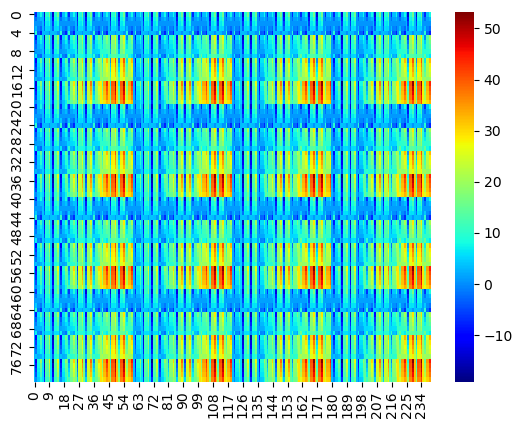

In [15]:
import seaborn as sns
ax =  sns.heatmap(pnl,  cmap="jet")

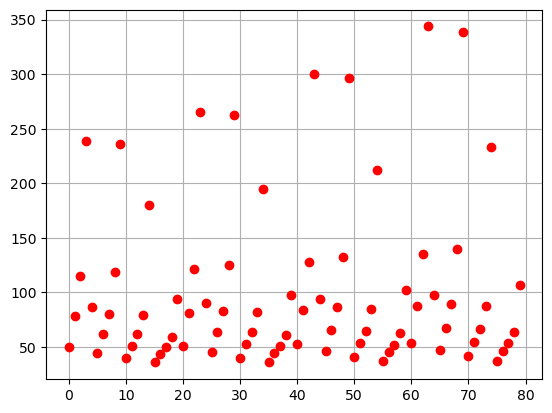

In [16]:
maxpnl =np.zeros([80])

korr =1./2
Maxi = 0
MaxS =-100
for i in range(80):
    maxpnl[i] =-korr*STEQ/min(-1,min(pnl[i,:]))*100
    #print("AA %d, Req %.2f Av %.2f Ratio %.1f"%(i,-min(pnl[i,:]),STEQ,maxpnl[i]))
    #print(repr(AssetAllocations[i]))
    #print(exppnl[i])
    #print("\n")

plt.plot(range(80),maxpnl,"ro")
plt.grid(True)

AA 54, Req 3.22 Av 13.69 Ratio 212.5
[54, 0.2, 0.2, 3]
2.3885884025306723


AA 69, Req 2.02 Av 13.69 Ratio 338.9
[69, 0.3, 0.1, 3]
2.0596619528470055


AA 74, Req 2.93 Av 13.69 Ratio 233.7
[74, 0.3, 0.2, 3]
2.718588402530672




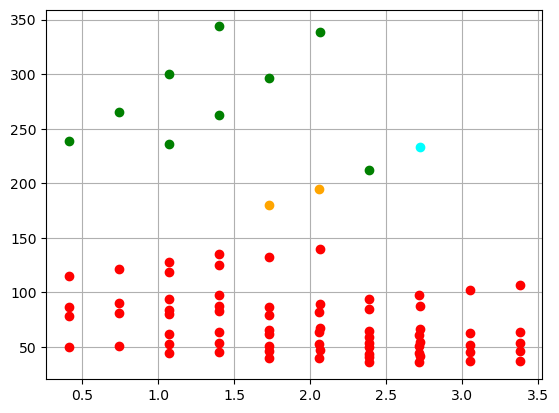

In [17]:
plt.figure(1)
for i in range(len(maxpnl)):
    x = maxpnl[i]
    y = exppnl[i]
    if x<=150: myc ="red"
    if x>150: myc="orange"
    if x>200: myc="green"
    if i ==74: myc="cyan"
    plt.plot([y],[x],"o",color=myc)
    
plt.grid(True)
plt.savefig("Ret_vs_Solva.png")

for i in range(len(maxpnl)):
    x = maxpnl[i]
    y = exppnl[i]
    if x>200 and exppnl[i] >2: 
        print("AA %d, Req %.2f Av %.2f Ratio %.1f"%(i,-min(pnl[i,:]),STEQ,maxpnl[i]))
        print(repr(AssetAllocations[i]))
        print(exppnl[i])
        print("\n")
    

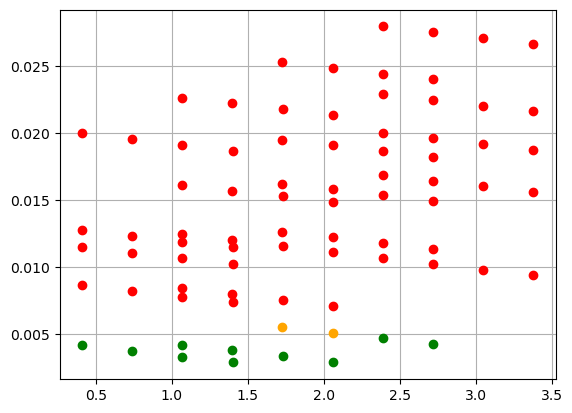

In [18]:
plt.figure(1)
for i in range(len(maxpnl)):
    x = maxpnl[i]
    y = exppnl[i]
    if x<=150: myc ="red"
    if x>150: myc="orange"
    if x>200: myc="green"
    if i ==95: myc="cyan"
    plt.plot([y],[1/x],"o",color=myc)
    
plt.grid(True)
plt.savefig("Ret_vs_Risk.png")

1607579436.8186631
4 360396722.09861267 440767477.28172153 0.22418594928772148
10 786503240.8844212 853611930.3001653 0.4892468906176608
15 1092383362.1330152 1239099401.2018971 0.6795206116189189
[4, 10, 15]
[0.4114853216889239, 0.17579018434876903, 0.1242349672047246]


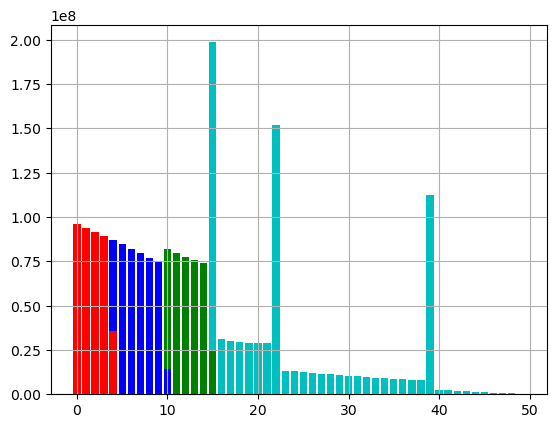

In [19]:
levels=[0.25,0.52,0.75]
iLevels =[]
pLevels =[]
coldict=['r','b','g','c']
x=[]
y=[]
b=[]
c=[]
v=0.98
PiT =0
for i in range(len(CFTA)): PiT += CFTA[i] * v**i
print(PiT)
PiTR = 0
iAlpha =0
alpha=levels[iAlpha]
col =[]
for i in range(len(CFTA)):
    if iAlpha != len(levels) and PiTR + CFTA[i] * v**i > alpha * PiT:
        print(i, PiTR, PiTR + CFTA[i] * v**i, PiTR/PiT)
        iLevels.append(i)
        part = (PiTR + CFTA[i] * v**i - alpha * PiT)/CFTA[i] * v**i
        pLevels.append(part)
        iAlpha +=1
        x.append(i)
        y.append(CFTA[i]*part)
        b.append(0.)
        c.append(coldict[iAlpha-1])
        x.append(i)
        y.append(CFTA[i]*(1-part))
        b.append(CFTA[i]*part)
        c.append(coldict[iAlpha])

    else:
        x.append(i)
        y.append(CFTA[i])
        b.append(0.)
        c.append(coldict[iAlpha])
    PiTR += CFTA[i] * v**i
    if(iAlpha != len(levels)): alpha=levels[iAlpha]
    
    

print(iLevels)
print(pLevels)

plt.figure(1)
plt.bar(x,y,bottom=b,color=c)
plt.grid(True)
plt.savefig("CfQuantiles.png")

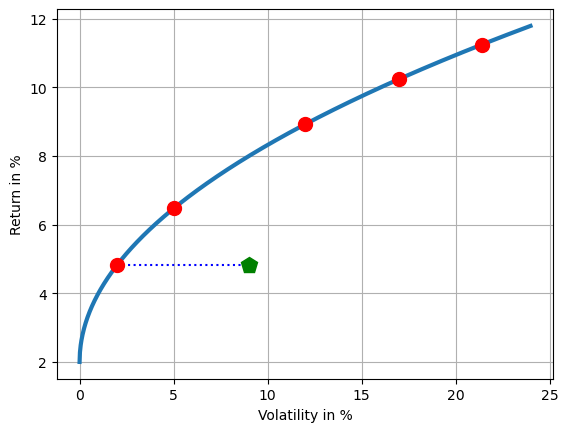

In [20]:
x=[]
y=[]
for i in range(1200):
    xx= 0.2*i/1000.
    x.append(xx*100)
    y.append(2 + 20*xx**0.5)
    
plt.figure(1)
xalpha =[0.02, 0.05,0.12, 0.17, 0.214]
yalpha =[]
yy = 2 + 20*xalpha[0]**0.5
plt.plot([100*xalpha[0],100*xalpha[0]+7],[yy,yy],":b")
plt.plot([100*xalpha[0]+7],[yy],'pg',markersize=12)
plt.plot(x,y,linewidth=3)

for i in xalpha:
    y = 2 + 20*i**0.5
    plt.plot([i*100],[y],'ro',markersize=10)

plt.grid(True)
plt.xlabel("Volatility in %")
plt.ylabel("Return in %")
plt.savefig("capm.png")